# Import Required Libraries
This section imports the necessary libraries for data processing and model building.

In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

/Users/mymac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 1) Read CSV Data
Load the training data from the CSV file and display basic information.

In [2]:
labeled_df = pd.read_csv("archive/train.csv")

# The 'id' column contains image file names, e.g., "00000.jpg"
# The 'has_cactus' column contains 0 or 1 (label)

print("Number of labeled data:", len(labeled_df))
print(labeled_df)

Number of labeled data: 17500
                                         id  has_cactus
0      0004be2cfeaba1c0361d39e2b000257b.jpg           1
1      000c8a36845c0208e833c79c1bffedd1.jpg           1
2      000d1e9a533f62e55c289303b072733d.jpg           1
3      0011485b40695e9138e92d0b3fb55128.jpg           1
4      0014d7a11e90b62848904c1418fc8cf2.jpg           1
...                                     ...         ...
17495  ffede47a74e47a5930f81c0b6896479e.jpg           0
17496  ffef6382a50d23251d4bc05519c91037.jpg           1
17497  fff059ecc91b30be5745e8b81111dc7b.jpg           1
17498  fff43acb3b7a23edcc4ae937be2b7522.jpg           0
17499  fffd9e9b990eba07c836745d8aef1a3a.jpg           1

[17500 rows x 2 columns]


Check for class unbalanced:

In [3]:
labeled_df['has_cactus'].value_counts()

has_cactus
1    13136
0     4364
Name: count, dtype: int64

# 2) Prepare Train & Validation Split
Split the dataset into training and validation sets for model evaluation.

In [4]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    labeled_df,
    test_size=0.4,
    random_state=42,
    stratify=labeled_df["has_cactus"]
)

print(f"Train size: {len(train_df)}, Temporary size: {len(temp_df)},")

validation_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["has_cactus"]
)

print(f"Validation size: {len(validation_df)}, Test size: {len(test_df)},")

Train size: 10500, Temporary size: 7000,
Validation size: 3500, Test size: 3500,


## 3) Image Data Generator


Use ImageDataGenerator for data augmentation and loading images from directories.



In [14]:
# Create the ImageDataGenerator objects that will be used to load the images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path to train images folder
train_dir = "archive/train/train/"
# path to test images folder
test_dir = "archive/test/test/"

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    target_size=(32, 32),   # image size
    batch_size=32,
    class_mode='raw',       # since our labels are 0/1, choose 'raw'
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    target_size=(32, 32),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=train_dir,
    x_col="id",
    y_col="has_cactus",
    target_size=(32, 32),
    batch_size=32,
    class_mode="raw",
    shuffle=False,
)

Found 10500 validated image filenames.
Found 3500 validated image filenames.
Found 3500 validated image filenames.


## 4) Build a Simple CNN Model


Define and compile a Convolutional Neural Network (CNN) model.

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # output 0/1
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

## 5) Training
Train the model for a specified number of epochs.


In [16]:
EPOCHS = 15

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Epoch 1/15


/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8473 - loss: 0.3487 - val_accuracy: 0.9389 - val_loss: 0.1622
Epoch 2/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9435 - loss: 0.1572 - val_accuracy: 0.9583 - val_loss: 0.1062
Epoch 3/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9592 - loss: 0.1190 - val_accuracy: 0.9686 - val_loss: 0.0861
Epoch 4/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9611 - loss: 0.1000 - val_accuracy: 0.9666 - val_loss: 0.0853
Epoch 5/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9679 - loss: 0.0877 - val_accuracy: 0.9717 - val_loss: 0.0787
Epoch 6/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9714 - loss: 0.0841 - val_accuracy: 0.9717 - val_loss: 0.0952
Epoch 7/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9699 - loss: 0.0858 - val_accuracy: 0.9783 - val_loss: 0.0574
Epoch 8/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9786 - loss: 0.0650 - val_accuracy: 0.9771

## 6) Evaluation / Visualization of Results (Optional)
Visualize the training and validation accuracy and loss.



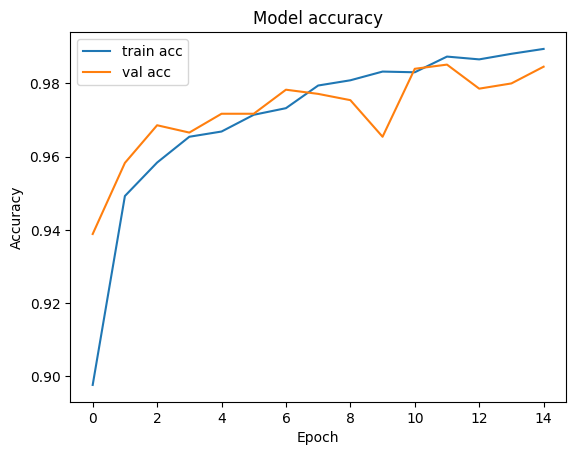

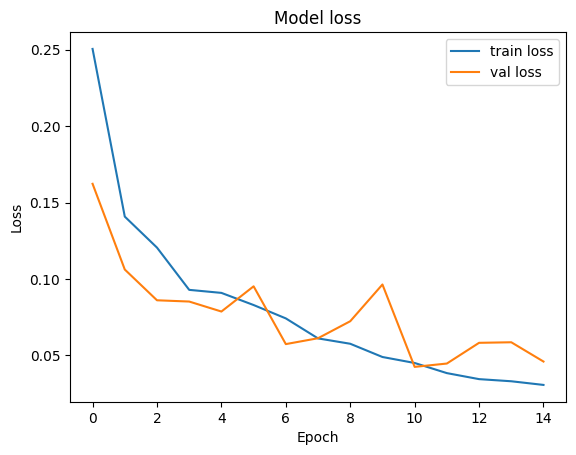

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7) Predict Test Data
Generate predictions for the test dataset. And evaluate their F1-score, AUC-ROC, and Confusion Matrix

In [ ]:
preds = model.predict(test_generator)
# Since we use sigmoid in the output, preds values are in the range [0..1]
# We can use a threshold of 0.5
pred_labels = (preds > 0.5).astype(int).reshape(-1)

# # Check the first 10 predictions
# print("Example predictions on test data:")
# for i in range(10):
#     print(test_df.iloc[i]['id'], "->", pred_labels[i])

# create f1 score
from sklearn.metrics import f1_score
f1 = f1_score(test_df['has_cactus'], pred_labels)
print("F1 score:", f1)

#create AUC-ROC score
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test_df['has_cactus'], pred_labels)
print("AUC-ROC score:", roc_auc)

#create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_df['has_cactus'], pred_labels)
print("Confusion matrix:\n", confusion_matrix)



110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
F1 score: 0.9881949733434882
AUC-ROC score: 0.9767272717759141
Confusion matrix:
 [[ 843   30]
 [  32 2595]]
